# Meta-Analytic Coactivation Modeling

In [1]:
# First, import the necessary modules and functions
import os

import matplotlib.pyplot as plt
from myst_nb import glue
from repo2data.repo2data import Repo2Data

from nimare import dataset

# Install the data if running locally, or points to cached data if running on neurolibre
DATA_REQ_FILE = os.path.abspath("../binder/data_requirement.json")
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.join(data_path[0], "data")

# Set an output directory for any files generated during the book building process
out_dir = os.path.abspath("../outputs/")

neurosynth_dset = dataset.Dataset.load(os.path.join(out_dir, "neurosynth_dataset.pkl.gz"))

---- repo2data starting ----
/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/repo2data
Config from file :
/home/data/nbc/misc-projects/Salo_NiMARE/binder/data_requirement.json
Destination:
./../data/nimare-paper

Info : ./../data/nimare-paper already downloaded


Meta-analytic coactivation modeling (MACM) {cite:p}`Laird2009-gc,Robinson2010-iv,Eickhoff2010-vx`, also known as meta-analytic connectivity modeling, uses meta-analytic data to measure co-occurrence of activations between brain regions providing evidence of functional connectivity of brain regions across tasks.
In coordinate-based MACM, whole-brain studies within the database are selected based on whether or not they report at least one peak in a region of interest specified for the analysis.
These studies are then subjected to a meta-analysis, often comparing the selected studies to those remaining in the database.
In this way, the significance of each voxel in the analysis corresponds to whether there is greater convergence of foci at the voxel among studies which also report foci in the region of interest than those which do not.

<!-- TODO: Determine appropriate citation style here. -->

MACM results have historically been accorded a similar interpretation to task-related functional connectivity (e.g., {cite:p}`Hok2015-lt,Kellermann2013-en`), although this approach is quite removed from functional connectivity analyses of task fMRI data (e.g., beta-series correlations, psychophysiological interactions, or even seed-to-voxel functional connectivity analyses on task data).
Nevertheless, MACM analyses do show high correspondence with resting-state functional connectivity {cite:p}`Reid2017-ez`.
MACM has been used to characterize the task-based functional coactivation of the cerebellum {cite:p}`Riedel2015-tx`, lateral prefrontal cortex {cite:p}`Reid2016-ba`, fusiform gyrus {cite:p}`Caspers2014-ja`, and several other brain regions.

Within NiMARE, MACMs can be performed by selecting studies in a Dataset based on the presence of activation within a target mask or coordinate-centered sphere.

In this section, we will perform two MACMs- one with a target mask and one with a coordinate-centered sphere.
For the former, we use {py:meth}`~nimare.dataset.Dataset.get_studies_by_mask`.
For the latter, we use {py:meth}`~nimare.dataset.Dataset.get_studies_by_coordinate`.

In [2]:
# Create Dataset only containing studies with peaks within the amygdala mask
amygdala_mask = os.path.join(data_path, "amygdala_roi.nii.gz")
amygdala_ids = neurosynth_dset.get_studies_by_mask(amygdala_mask)
dset_amygdala = neurosynth_dset.slice(amygdala_ids)

# Create Dataset only containing studies with peaks within the sphere ROI
sphere_ids = neurosynth_dset.get_studies_by_coordinate([[24, -2, -20]], r=6)
dset_sphere = neurosynth_dset.slice(sphere_ids)

```{important}
The amygdala dataset includes more than 1300 studies.
Running a meta-analysis on such a large dataset may require more than 4 GB of RAM, which is NeuroLibre's limit.
Therefore, we will further reduce the Dataset to its first 500 studies, in order to run the meta-analysis successfully on NeuroLibre's server.
For publication-quality analyses, we would recommend using the entire Dataset.
```

In [3]:
print(dset_amygdala)
dset_amygdala = dset_amygdala.slice(dset_amygdala.ids[:500])
print(dset_amygdala)

Dataset(1369 experiments, space='mni152_2mm')
Dataset(500 experiments, space='mni152_2mm')


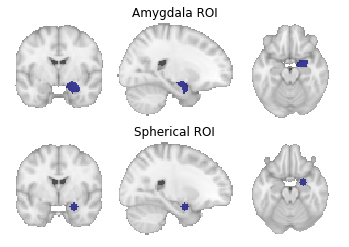

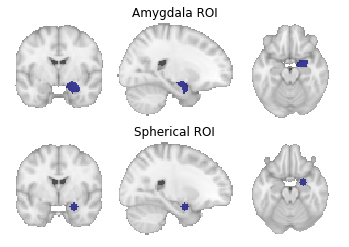

In [4]:
import numpy as np
from nilearn import input_data, plotting

# In order to plot a sphere with a precise radius around a coordinate with
# nilearn, we need to use a NiftiSpheresMasker
mask_img = neurosynth_dset.masker.mask_img
sphere_masker = input_data.NiftiSpheresMasker([[24, -2, -20]], radius=6, mask_img=mask_img)
sphere_masker.fit(mask_img)
sphere_img = sphere_masker.inverse_transform(np.array([[1]]))

fig, axes = plt.subplots(figsize=(6, 4), nrows=2)
display = plotting.plot_roi(
    amygdala_mask,
    annotate=False,
    draw_cross=False,
    axes=axes[0],
    figure=fig,
)
axes[0].set_title("Amygdala ROI")
display = plotting.plot_roi(
    sphere_img,
    annotate=False,
    draw_cross=False,
    axes=axes[1],
    figure=fig,
)
axes[1].set_title("Spherical ROI")
glue("figure_macm_rois", fig, display=False)

```{glue:figure} figure_macm_rois
:name: figure_macm_rois
:align: center

Region of interest masks for (1) a target mask-based MACM and (2) a coordinate-based MACM.
```

Once the `Dataset` has been reduced to studies with coordinates within the mask or sphere requested, any of the supported CBMA Estimators can be run.

In [5]:
from nimare import meta

meta_amyg = meta.cbma.ale.ALE(kernel__sample_size=20)
results_amyg = meta_amyg.fit(dset_amygdala)

meta_sphere = meta.cbma.ale.ALE(kernel__sample_size=20)
results_sphere = meta_sphere.fit(dset_sphere)

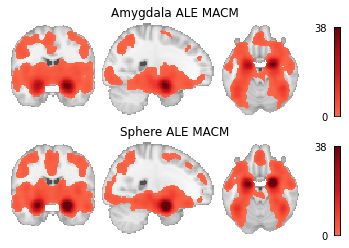

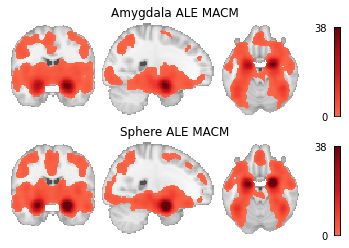

In [6]:
meta_results = {
    "Amygdala ALE MACM": results_amyg.get_map("z", return_type="image"),
    "Sphere ALE MACM": results_sphere.get_map("z", return_type="image"),
}

fig, axes = plt.subplots(figsize=(6, 4), nrows=2)
for i_meta, (name, file_) in enumerate(meta_results.items()):
    display = plotting.plot_stat_map(
        file_,
        annotate=False,
        axes=axes[i_meta],
        cmap="Reds",
        cut_coords=[24, -2, -20],
        draw_cross=False,
        figure=fig,
    )
    axes[i_meta].set_title(name)

    colorbar = display._cbar
    colorbar_ticks = colorbar.get_ticks()
    if colorbar_ticks[0] < 0:
        new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
    else:
        new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
    colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_macm", fig, display=False)

```{glue:figure} figure_macm
:name: figure_macm
:align: center

Unthresholded z-statistic maps for (1) the target mask-based MACM and (2) the coordinate-based MACM.
```